In [1]:
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import statsmodels.api as sm
sns.set_context('talk')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [8]:
avg_t = pd.read_csv("cag_csvs/tavg.csv", index_col='Date', parse_dates=['Date'])
cdd = pd.read_csv("cag_csvs/cdd.csv", index_col='Date', parse_dates=['Date'])
pcp = pd.read_csv("cag_csvs/pcp.csv", index_col='Date', parse_dates=['Date'])

CA_avg_t = avg_t['CA']
CA_cdd = cdd['CA']
CA_pcp = pcp['CA']

rolmean_CA_avg_t = CA_avg_t.rolling(60).mean().dropna()
rolmean_CA_cdd = CA_cdd.rolling(60).mean().dropna()
rolmean_CA_pcp = CA_pcp.rolling(60).mean().dropna()


Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-230.803, BIC=-225.738, Fit time=0.094 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-243.446, BIC=-233.315, Fit time=1.070 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-249.807, BIC=-239.676, Fit time=0.461 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-231.988, BIC=-224.391, Fit time=0.104 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-240.718, BIC=-228.055, Fit time=0.469 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-227.988, BIC=-215.325, Fit time=1.192 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=-244.115, BIC=-233.985, Fit time=0.386 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-239.192, BIC=-223.997, Fit time=2.574 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-248.461, BIC=-240.863, Fit time=0.639 seconds
Fit ARIMA: order=(1, 1, 1) s

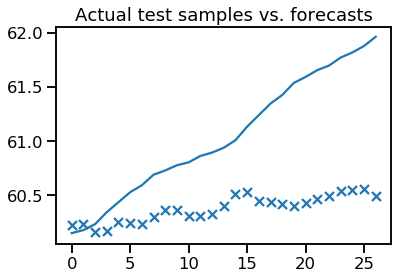

In [18]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# #############################################################################
# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(rolmean_CA_avg_t['2008':], 
                                               train_size=round(len(rolmean_CA_avg_t['2008':])*0.8))

# Fit a simple auto_arima model
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12,
                      start_p=0, start_q=0,
                      start_P=0, start_Q=0,
                      stationary=False,
                      with_intercept=False,
                      D=1,
                      trend='t'
                      )

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

In [16]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 130.030
Date:                            Wed, 08 Jan 2020   AIC                           -252.060
Time:                                    16:30:34   BIC                           -241.929
Sample:                                         0   HQIC                          -247.969
                                            - 106                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0066      0.004      1.574      0.116      -0.002       0.015
ma.L1          0.2219      0.110      2.026      0.043       0.007       0.436
ma.S.L12      -0.6216      0.126     -4.944      0.000      -0.868      -0.375
sigma2         0.0034      0.001      5.516      0.000       0.002       0.005
===================================================================================
Ljung-Box (Q):                       26.86   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.94   Prob(JB):                         0.38
Heteroskedasticity (H):               0.55   Skew:                            -0.22
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""